知识就是常写常新，常看常新。又到了定期手撕 Transformer 的季节。

计算注意力的流程可以分解为以下两个步骤：
- 计算 Q 和 K 的相似度；
- 根据计算得到的相似度，取出 V 每条信息中和 Q 有关的内容；

注意力机制本身并没有对 Q，K 和 V 的内容做出任何限制。比如，我们现在希望计算音频和文本之间的注意力，或者说希望从音频特征中提取和文本相关的信息，那么这个时候应该将文本特征作为 Q，音频特征作为 K 和 V（交叉注意力机制）；又比如，我们希望计算文本和文本自身的注意力，那么就应该将文本特征同时作为 
Q，K 和 V（自注意力机制）。

如下，可以假设图像切后有 100 个 tokens，而文本有 256 个 tokens。现在就能通过注意力算子计算出**用图像语义信息当作查询、从“文本数据库”中软检索出的相关知识**。头数按照 GPT-2 的设置来。

In [13]:
q_len, k_len, v_len = 100, 256, 256

batch_size = 32
hidden_dim = 768
head_dim = 64

如下是切分头和合并头的操作。之所以切分头是要最后两个维度是 len 和 hidden dim per head，方便进行矩阵运算（前面的维度会自动 broadcast）。

In [19]:
import torch
def split_head(x: torch.tensor, num_heads=12):
    b, l, h = x.size()
    x = x.reshape(b, l, num_heads, h // num_heads).transpose(1, 2)
    return x

x = torch.randn(batch_size, q_len, hidden_dim)
x = split_head(x, num_heads=12)
x.shape

torch.Size([32, 12, 100, 64])

In [25]:
def merge_head(x: torch.tensor):
    b, num_heads, l, h_per_heads = x.size()
    x = x.transpose(1, 2).reshape(b, l, num_heads * h_per_heads)
    return x

merge_head(x).shape

torch.Size([32, 100, 768])

以下是几种等效写法，比如 transpose 可以换成 permute；reshape 可以用 view 替代；用 ein 表达式更快。

In [24]:
x = torch.randn(32, 12, 100, 64)

x1 = x.transpose(1, 2).reshape(32, 100, 64 * 12)
x2 = x.permute(0, 2, 1, 3).reshape(32, 100, 64 * 12)
x3 = x.transpose(1, 2).contiguous().view(32, 100, 64 * 12)

from einops import rearrange
x4 = rearrange(x, 'b h l d -> b l (h d)')

torch.allclose(x1, x2), torch.allclose(x1, x3), torch.allclose(x1, x4)

(True, True, True)

如下，Q、K 和 V 在分头后最后两维会进行运算，第二维是不同的 heads。

In [28]:
q, k, v = torch.randn(32, 100, 768), torch.randn(32, 256, 768), torch.randn(32, 256, 768)
q, k, v = map(split_head, (q, k, v))
q.shape, k.shape, v.shape

(torch.Size([32, 12, 100, 64]),
 torch.Size([32, 12, 256, 64]),
 torch.Size([32, 12, 256, 64]))

有关 padding，是在每层的、每个头的 attention-mask 上都套上一个 padding mask，以确保这些部分激活值为 0。这意味着 value 不会从这些位置分配到权重，在反传时，这些位置也不会有梯度的。

Text(0, 0.5, 'Query positions')

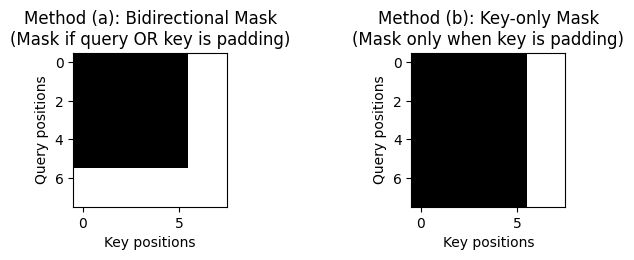

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# First, let's create some demo data with padding
batch_size, seq_len, d_model = 2, 8, 512
# Create sequences with different lengths (simulating padding)
# Sequence 1: actual length 6, padded to 8
# Sequence 2: actual length 4, padded to 8
actual_lengths = [6, 4]

# Create attention scores (before softmax)
attention_scores = torch.randn(batch_size, seq_len, seq_len)

# Method (a): Bidirectional padding mask - mask if either query OR key is padding
def create_bidirectional_padding_mask(actual_lengths, seq_len, batch_size):
    mask = torch.ones(batch_size, seq_len, seq_len, dtype=torch.bool)
    for b, length in enumerate(actual_lengths):
        # Keep only the valid positions (both query and key are valid)
        mask[b, :length, :length] = False
    return mask

# Method (b): Key-only padding mask - mask only when key is padding
def create_key_padding_mask(actual_lengths, seq_len, batch_size):
    mask = torch.ones(batch_size, seq_len, seq_len, dtype=torch.bool)
    for b, length in enumerate(actual_lengths):
        # For each query position, mask only the padded key positions
        mask[b, :, :length] = False
    return mask

# Create both types of masks
bidirectional_mask = create_bidirectional_padding_mask(actual_lengths, seq_len, batch_size)
key_only_mask = create_key_padding_mask(actual_lengths, seq_len, batch_size)

# Visualize the masks
fig, axes = plt.subplots(1, 2, figsize=(8, 2))

# Visualize masks for batch 0 (sequence length 6)
im1 = axes[0].imshow(bidirectional_mask[0].numpy(), cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Method (a): Bidirectional Mask\n(Mask if query OR key is padding)')
axes[0].set_xlabel('Key positions')
axes[0].set_ylabel('Query positions')

im2 = axes[1].imshow(key_only_mask[0].numpy(), cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Method (b): Key-only Mask\n(Mask only when key is padding)')
axes[1].set_xlabel('Key positions')
axes[1].set_ylabel('Query positions')

In [17]:
masked_scores = attention_scores.masked_fill(bidirectional_mask, float('-inf'))
attention_weights_a = torch.softmax(masked_scores, dim=-1)
attention_weights_a

tensor([[[0.0470, 0.1679, 0.5896, 0.0649, 0.0788, 0.0518, 0.0000, 0.0000],
         [0.1321, 0.1649, 0.0215, 0.2950, 0.1312, 0.2553, 0.0000, 0.0000],
         [0.2348, 0.4515, 0.0067, 0.0376, 0.1609, 0.1084, 0.0000, 0.0000],
         [0.1893, 0.1366, 0.3029, 0.1564, 0.0532, 0.1616, 0.0000, 0.0000],
         [0.0314, 0.0410, 0.1565, 0.0374, 0.1777, 0.5560, 0.0000, 0.0000],
         [0.0035, 0.0750, 0.0597, 0.7438, 0.0145, 0.1036, 0.0000, 0.0000],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan]],

        [[0.0825, 0.3683, 0.4014, 0.1478, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0159, 0.3444, 0.4999, 0.1397, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4687, 0.1961, 0.2373, 0.0979, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1811, 0.0672, 0.1142, 0.6375, 0.0000, 0.0000, 0.0000, 0.0000],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan],
         [   nan,    na

In [18]:
masked_scores = attention_scores.masked_fill(key_only_mask, float('-inf'))
attention_weights_b = torch.softmax(masked_scores, dim=-1)
attention_weights_b

tensor([[[0.0470, 0.1679, 0.5896, 0.0649, 0.0788, 0.0518, 0.0000, 0.0000],
         [0.1321, 0.1649, 0.0215, 0.2950, 0.1312, 0.2553, 0.0000, 0.0000],
         [0.2348, 0.4515, 0.0067, 0.0376, 0.1609, 0.1084, 0.0000, 0.0000],
         [0.1893, 0.1366, 0.3029, 0.1564, 0.0532, 0.1616, 0.0000, 0.0000],
         [0.0314, 0.0410, 0.1565, 0.0374, 0.1777, 0.5560, 0.0000, 0.0000],
         [0.0035, 0.0750, 0.0597, 0.7438, 0.0145, 0.1036, 0.0000, 0.0000],
         [0.1478, 0.1969, 0.0946, 0.0847, 0.2023, 0.2738, 0.0000, 0.0000],
         [0.0210, 0.2369, 0.0473, 0.0780, 0.6058, 0.0109, 0.0000, 0.0000]],

        [[0.0825, 0.3683, 0.4014, 0.1478, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0159, 0.3444, 0.4999, 0.1397, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4687, 0.1961, 0.2373, 0.0979, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1811, 0.0672, 0.1142, 0.6375, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0796, 0.1536, 0.2401, 0.5267, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3447, 0.366

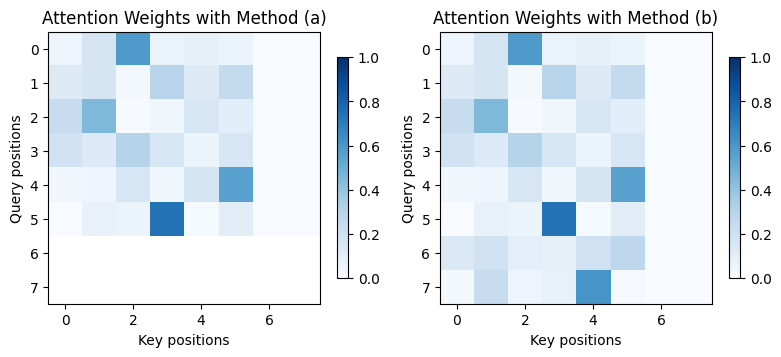

Analysis of potential NaN issues:
Method (a) - NaN in attention weights: True
Method (b) - NaN in attention weights: False

Attention weights for padded query position 6 (batch 0):
Method (a): tensor([nan, nan, nan, nan, nan, nan, nan, nan])
Method (b): tensor([0.1478, 0.1969, 0.0946, 0.0847, 0.2023, 0.2738, 0.0000, 0.0000])

Loss calculation demonstration:
Target tokens (batch 0): tensor([543, 324, 207, 980, 892, 143, 999, 999])
Padding positions marked with token 999
Loss with ignore_index: 7.3756
Loss without ignore_index: 7.4974


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

im3 = axes[0].imshow(attention_weights_a[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
axes[0].set_title('Attention Weights with Method (a)')
axes[0].set_xlabel('Key positions')
axes[0].set_ylabel('Query positions')

im4 = axes[1].imshow(attention_weights_b[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Attention Weights with Method (b)')
axes[1].set_xlabel('Key positions')
axes[1].set_ylabel('Query positions')


plt.colorbar(im3, ax=axes[0], shrink=0.6)
plt.colorbar(im4, ax=axes[1], shrink=0.6)

plt.tight_layout()
plt.show()

# Check for NaN values
print("Analysis of potential NaN issues:")
print(f"Method (a) - NaN in attention weights: {torch.isnan(attention_weights_a).any()}")
print(f"Method (b) - NaN in attention weights: {torch.isnan(attention_weights_b).any()}")

# Show specific problematic rows (padded query positions)
print(f"\nAttention weights for padded query position 6 (batch 0):")
print(f"Method (a): {attention_weights_a[0, 6]}")
print(f"Method (b): {attention_weights_b[0, 6]}")

# Demonstrate the loss calculation with ignore_index
print("\n" + "="*50)
print("Loss calculation demonstration:")

# Create dummy logits and targets
vocab_size = 1000
ignore_token_id = 999  # Special token for padding

# Simulate logits for a sequence
logits = torch.randn(batch_size, seq_len, vocab_size)
targets = torch.randint(0, vocab_size-1, (batch_size, seq_len))

# Set padding positions to ignore_token_id
for b, length in enumerate(actual_lengths):
    targets[b, length:] = ignore_token_id

print(f"Target tokens (batch 0): {targets[0]}")
print(f"Padding positions marked with token {ignore_token_id}")

# Calculate loss with and without ignore_index
loss_with_ignore = torch.nn.functional.cross_entropy(
    logits.view(-1, vocab_size), targets.view(-1), ignore_index=ignore_token_id
)
loss_without_ignore = torch.nn.functional.cross_entropy(
    logits.view(-1, vocab_size), targets.view(-1)
)

print(f"Loss with ignore_index: {loss_with_ignore:.4f}")
print(f"Loss without ignore_index: {loss_without_ignore:.4f}")

当然，causal mask，中文直译为“因果掩码”。所谓因果，实际上可以看作一种 dropout；这种 heuristic 来源于直觉性的观察，即 LM 语言建模。但随着社区对 mask 的探索充分化后，mask 语境也逐渐丰富。

In [27]:
import torch

torch.triu(torch.ones(1, 10, 10), diagonal=1).bool()

tensor([[[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
         [False, False, False,  True,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False, False,  True,  True,  True,  True,  True],
         [False, False, False, False, False, False,  True,  True,  True,  True],
         [False, False, False, False, False, False, False,  True,  True,  True],
         [False, False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False, False, False]]])

如下是我个人最习惯的一次 MHA 前向的写法，没有考虑 batch padding 的问题。可以参考着 Transformer 原文中的注意力机制框架图进行复现。 


<div align="center">
<img src="https://aiml.com/wp-content/uploads/2023/09/Self-Attention-vs-Multi-headed-Attention-2048x1095.png" alt="Multi-Head Attention" width="40%">
</div>

In [95]:
import torch

B, T, head, hdim = 32, 100, 12, 64
X = torch.randn(B, T, head*hdim, dtype=torch.float32)
print('X:', X.shape)

Wq = torch.nn.Linear(head*hdim, head*hdim)
Wk = torch.nn.Linear(head*hdim, head*hdim)
Wv = torch.nn.Linear(head*hdim, head*hdim)
Wo = torch.nn.Linear(head*hdim, head*hdim)

Q, K, V= Wq(X), Wk(X), Wv(X)
Q = Q.view(B, T, -1, hdim).permute(0, 2, 1, 3)
K = K.view(B, T, -1, hdim).permute(0, 2, 1, 3)
V = V.view(B, T, -1, hdim).permute(0, 2, 1, 3)
print('Q:', Q.shape)

attn = Q @ K.transpose(-2, -1) / torch.sqrt(torch.tensor(hdim))
print('attn:', attn.shape)

mask = torch.triu(torch.ones_like(attn), diagonal=1).bool()
attn = torch.masked_fill(attn, mask, value=float('-inf'))
attn = torch.softmax(attn, dim=-1)
attn = torch.nn.Dropout(p=0.1)(attn)

out = attn @ V
out = out.permute(0, 2, 1, 3).reshape(B, T, -1)
out = Wo(out)
print('out:', out.shape)

X: torch.Size([32, 100, 768])
Q: torch.Size([32, 12, 100, 64])
attn: torch.Size([32, 12, 100, 100])
out: torch.Size([32, 100, 768])


$$\begin{aligned}P E(\text { pos }, 2 i) & =\sin \left(\text { pos } / 10000^{2 i / d_{\text {model }}}\right) \\P E(\text { pos }, 2 i+1) & =\cos \left(\text { pos } / 10000^{2 i / d_{\text {model }}}\right)\end{aligned}$$

下面是一种比较简单的实现。

In [144]:
X = torch.randn(B, T, hdim)
embeddings = torch.zeros_like(X[0].squeeze())
for i in range(hdim):
    func = torch.sin if i % 2 == 0 else torch.cos
    embeddings[:, i] = func(torch.arange(0, T) / torch.pow(torch.tensor(1e4), 2 * (i // 2) / hdim))

X += embeddings
X.shape

torch.Size([32, 100, 64])

如下是一种更 pythonic 的实现。

In [151]:
embeddings_new = torch.zeros_like(X[0].squeeze())
pos = torch.arange(T).unsqueeze(1)
dim = torch.arange(0, hdim, 2)
div_term = torch.pow(10000.0, dim / hdim)  # 10000^(2i/d_model)
embeddings_new[:, 0::2] = torch.sin(pos / div_term)
embeddings_new[:, 1::2] = torch.cos(pos / div_term)

torch.allclose(embeddings_new, embeddings)

True

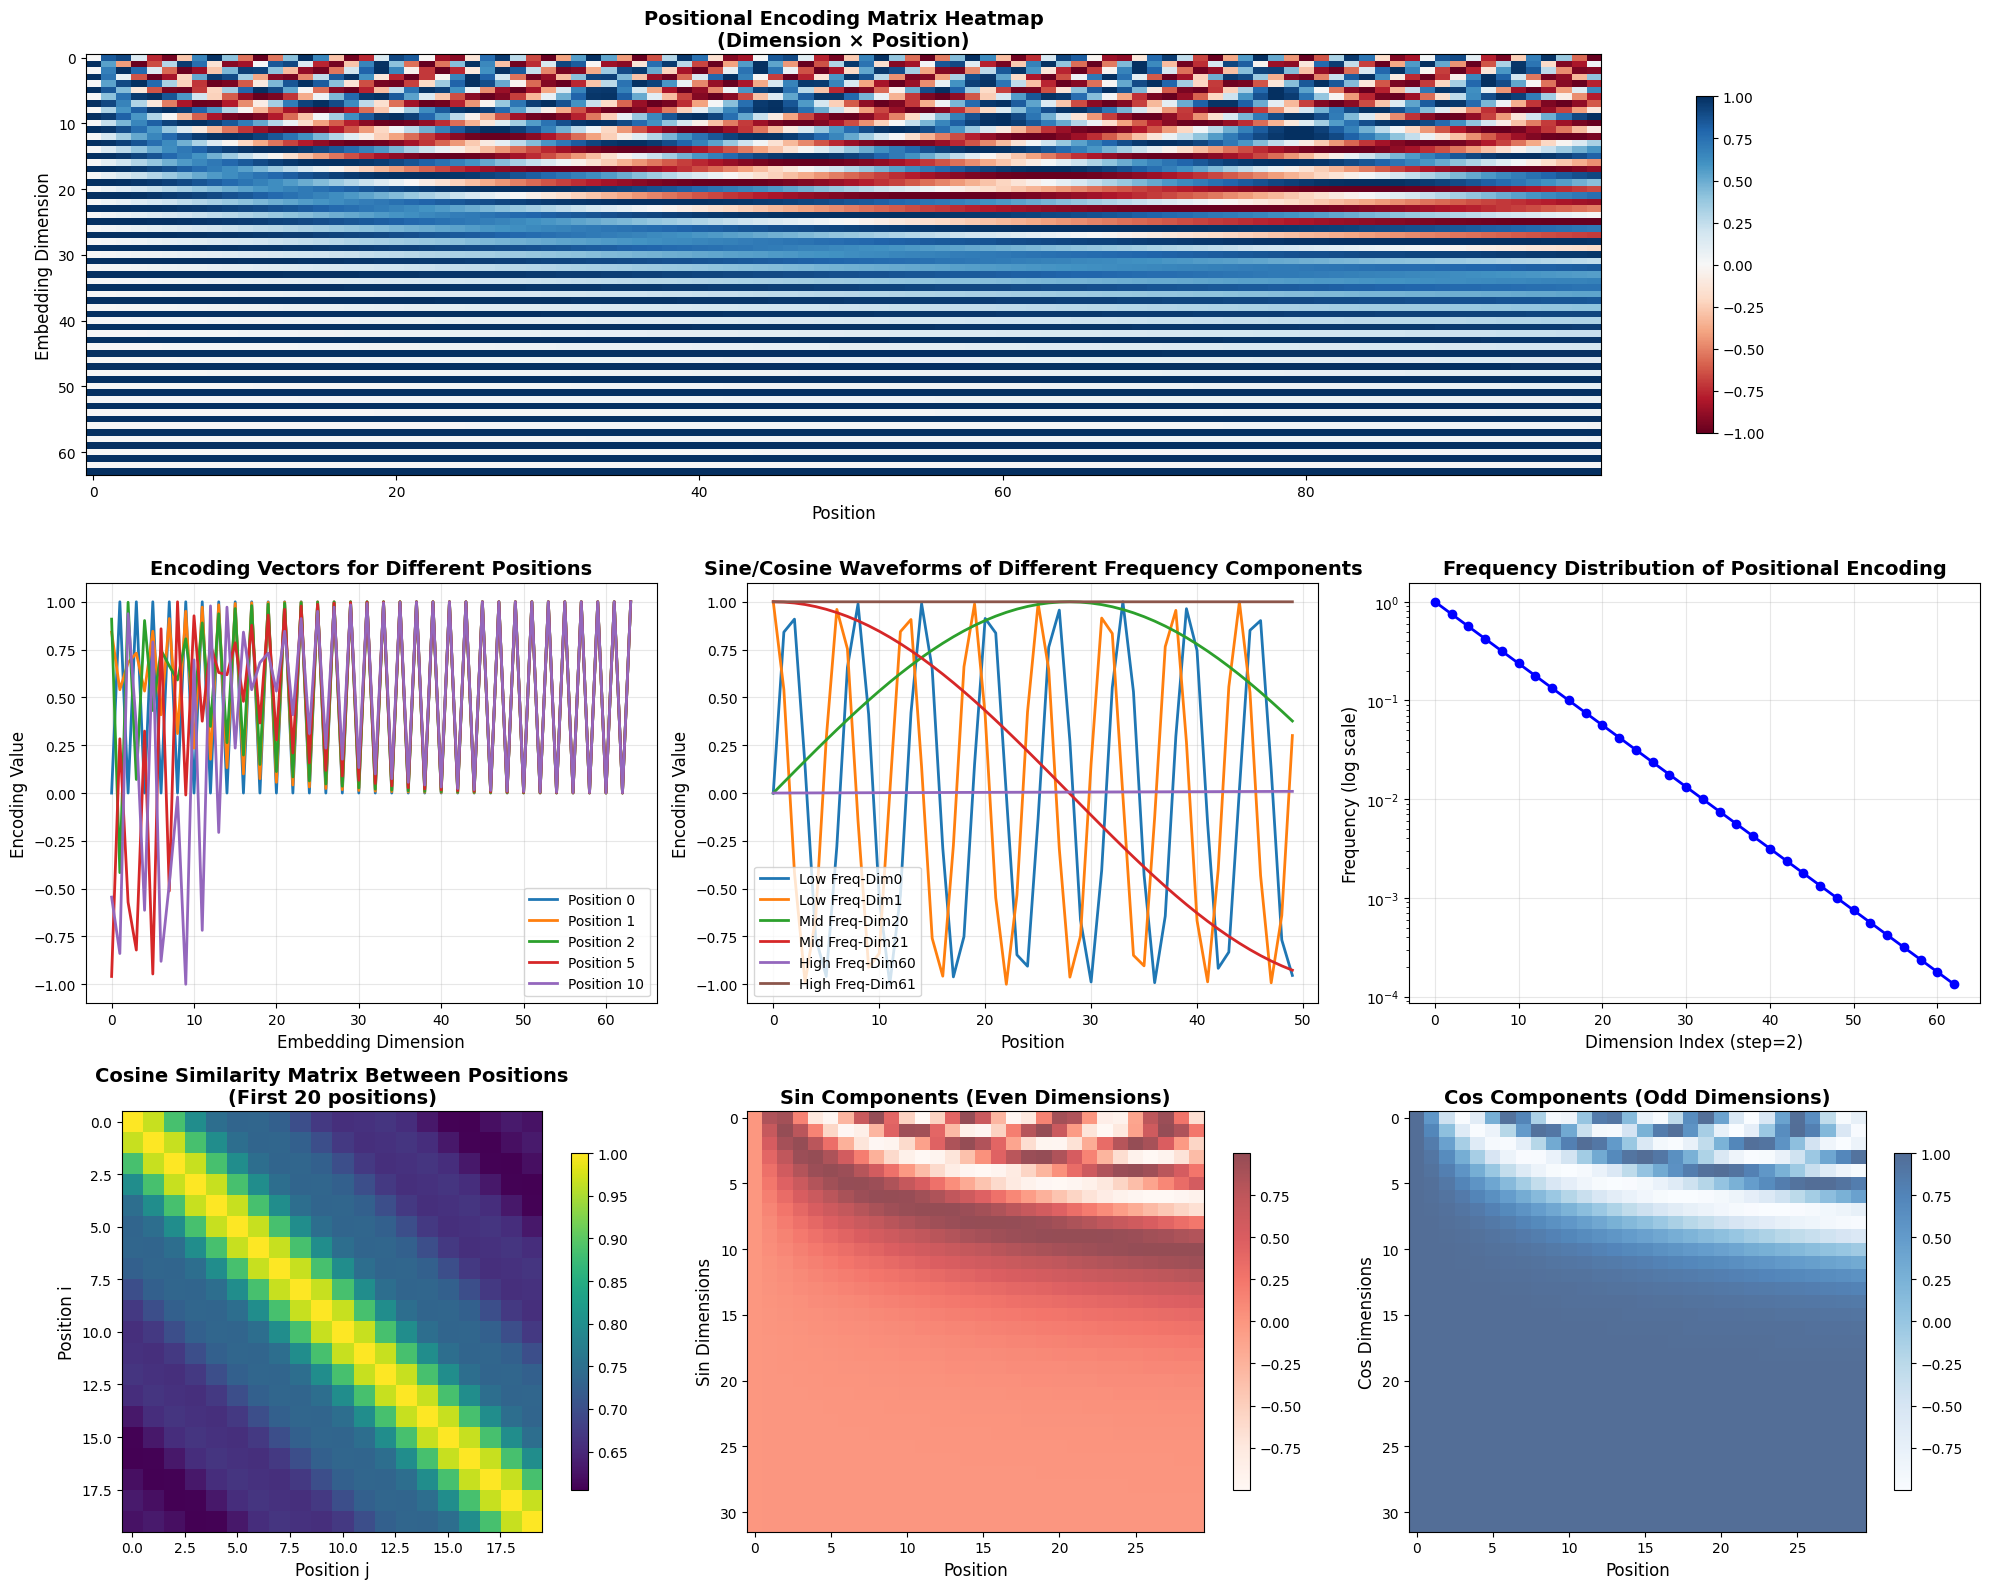

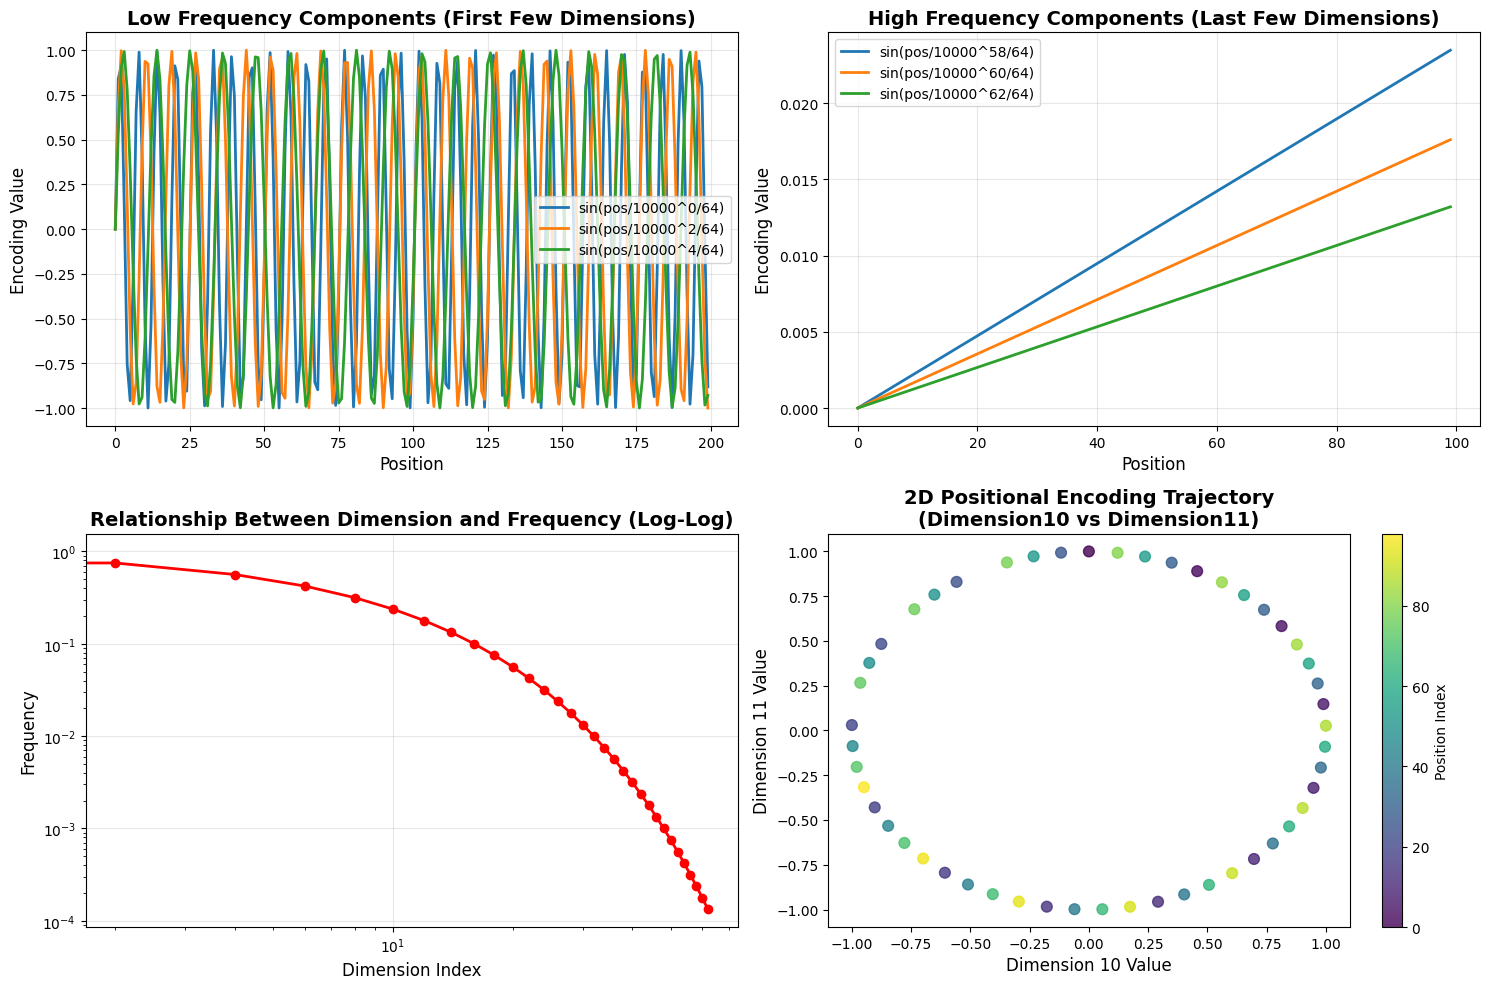

Positional Encoding Statistics:
Sequence Length: 100
Embedding Dimension: 64
Encoding Matrix Shape: torch.Size([100, 64])
Encoding Value Range: [-1.000, 1.000]
Encoding Matrix Mean: 0.347416
Encoding Matrix Std: 0.615923
Average Cosine Similarity Between Adjacent Positions: 0.966151
Cosine Similarity Between Position 0 and Position 1: 0.966151


In [152]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

T = 100  # sequence length
hdim = 64  # embedding dimension
B = 1

# Correct positional embedding implementation
def create_positional_encoding(T, hdim):
    embeddings = torch.zeros(T, hdim)
    for i in range(hdim):
        func = torch.sin if i % 2 == 0 else torch.cos
        embeddings[:, i] = func(torch.arange(0, T) / torch.pow(torch.tensor(1e4), 2 * (i // 2) / hdim))
    return embeddings

# Create positional encoding
pos_encoding = create_positional_encoding(T, hdim)

# Create large figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. Overall visualization of positional encoding matrix
ax1 = plt.subplot(3, 3, (1, 3))
im1 = ax1.imshow(pos_encoding.T, cmap='RdBu', aspect='auto', interpolation='nearest')
ax1.set_title('Positional Encoding Matrix Heatmap\n(Dimension × Position)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Position', fontsize=12)
ax1.set_ylabel('Embedding Dimension', fontsize=12)
plt.colorbar(im1, ax=ax1, shrink=0.8)

# 2. Encoding values for first few positions
ax2 = plt.subplot(3, 3, 4)
positions_to_show = [0, 1, 2, 5, 10]
for pos in positions_to_show:
    ax2.plot(pos_encoding[pos], label=f'Position {pos}', linewidth=2)
ax2.set_title('Encoding Vectors for Different Positions', fontsize=14, fontweight='bold')
ax2.set_xlabel('Embedding Dimension', fontsize=12)
ax2.set_ylabel('Encoding Value', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Visualization of high and low frequency components
ax3 = plt.subplot(3, 3, 5)
# Select dimensions with different frequencies
low_freq_dims = [0, 1]  # low frequency components
mid_freq_dims = [20, 21]  # mid frequency components  
high_freq_dims = [60, 61]  # high frequency components

positions = torch.arange(T)

for dim in low_freq_dims:
    func = torch.sin if dim % 2 == 0 else torch.cos
    values = func(positions / torch.pow(torch.tensor(1e4), 2 * (dim // 2) / hdim))
    ax3.plot(positions[:50], values[:50], label=f'Low Freq-Dim{dim}', linewidth=2)

for dim in mid_freq_dims:
    func = torch.sin if dim % 2 == 0 else torch.cos
    values = func(positions / torch.pow(torch.tensor(1e4), 2 * (dim // 2) / hdim))
    ax3.plot(positions[:50], values[:50], label=f'Mid Freq-Dim{dim}', linewidth=2)

for dim in high_freq_dims:
    func = torch.sin if dim % 2 == 0 else torch.cos
    values = func(positions / torch.pow(torch.tensor(1e4), 2 * (dim // 2) / hdim))
    ax3.plot(positions[:50], values[:50], label=f'High Freq-Dim{dim}', linewidth=2)

ax3.set_title('Sine/Cosine Waveforms of Different Frequency Components', fontsize=14, fontweight='bold')
ax3.set_xlabel('Position', fontsize=12)
ax3.set_ylabel('Encoding Value', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Frequency spectrum analysis
ax4 = plt.subplot(3, 3, 6)
# Calculate frequency for each dimension
frequencies = []
for i in range(hdim // 2):
    freq = 1 / torch.pow(torch.tensor(1e4), 2 * i / hdim)
    frequencies.append(freq.item())

ax4.semilogy(range(0, hdim, 2), frequencies, 'bo-', linewidth=2, markersize=6)
ax4.set_title('Frequency Distribution of Positional Encoding', fontsize=14, fontweight='bold')
ax4.set_xlabel('Dimension Index (step=2)', fontsize=12)
ax4.set_ylabel('Frequency (log scale)', fontsize=12)
ax4.grid(True, alpha=0.3)

# 5. Similarity matrix between adjacent positions
ax5 = plt.subplot(3, 3, 7)
# Calculate cosine similarity between first 20 positions
similarity_matrix = torch.zeros(20, 20)
for i in range(20):
    for j in range(20):
        cos_sim = torch.nn.functional.cosine_similarity(
            pos_encoding[i:i+1], pos_encoding[j:j+1], dim=1
        )
        similarity_matrix[i, j] = cos_sim

im5 = ax5.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
ax5.set_title('Cosine Similarity Matrix Between Positions\n(First 20 positions)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Position j', fontsize=12)
ax5.set_ylabel('Position i', fontsize=12)
plt.colorbar(im5, ax=ax5, shrink=0.8)

# 6. Distribution of Sin components
ax6 = plt.subplot(3, 3, 8)
sin_dims = pos_encoding[:30, 0::2]  # even dimensions (sin)
cos_dims = pos_encoding[:30, 1::2]  # odd dimensions (cos)

im6_sin = ax6.imshow(sin_dims.T, cmap='Reds', aspect='auto', alpha=0.7)
ax6.set_title('Sin Components (Even Dimensions)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Position', fontsize=12)
ax6.set_ylabel('Sin Dimensions', fontsize=12)
plt.colorbar(im6_sin, ax=ax6, shrink=0.8)

# 7. Cos components
ax7 = plt.subplot(3, 3, 9)
im7_cos = ax7.imshow(cos_dims.T, cmap='Blues', aspect='auto', alpha=0.7)
ax7.set_title('Cos Components (Odd Dimensions)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Position', fontsize=12)
ax7.set_ylabel('Cos Dimensions', fontsize=12)
plt.colorbar(im7_cos, ax=ax7, shrink=0.8)

plt.tight_layout()
plt.show()

# Create an additional specialized high/low frequency comparison plot
fig2, axes = plt.subplots(2, 2, figsize=(15, 10))

# Detailed display of low frequency components
positions_extended = torch.arange(200)
ax_low = axes[0, 0]
for i in [0, 2, 4]:
    func = torch.sin if i % 2 == 0 else torch.cos
    values = func(positions_extended / torch.pow(torch.tensor(1e4), 2 * (i // 2) / hdim))
    func_name = 'sin' if i % 2 == 0 else 'cos'
    ax_low.plot(positions_extended, values, label=f'{func_name}(pos/10000^{2*(i//2)}/{hdim})', linewidth=2)
ax_low.set_title('Low Frequency Components (First Few Dimensions)', fontsize=14, fontweight='bold')
ax_low.set_xlabel('Position', fontsize=12)
ax_low.set_ylabel('Encoding Value', fontsize=12)
ax_low.legend()
ax_low.grid(True, alpha=0.3)

# Detailed display of high frequency components
ax_high = axes[0, 1]
for i in [58, 60, 62]:
    func = torch.sin if i % 2 == 0 else torch.cos
    values = func(positions_extended / torch.pow(torch.tensor(1e4), 2 * (i // 2) / hdim))
    func_name = 'sin' if i % 2 == 0 else 'cos'
    ax_high.plot(positions_extended[:100], values[:100], label=f'{func_name}(pos/10000^{2*(i//2)}/{hdim})', linewidth=2)
ax_high.set_title('High Frequency Components (Last Few Dimensions)', fontsize=14, fontweight='bold')
ax_high.set_xlabel('Position', fontsize=12)
ax_high.set_ylabel('Encoding Value', fontsize=12)
ax_high.legend()
ax_high.grid(True, alpha=0.3)

# Relationship between dimension and frequency
ax_freq = axes[1, 0]
all_freqs = []
dim_indices = []
for i in range(0, hdim, 2):
    freq = 1 / torch.pow(torch.tensor(1e4), 2 * (i // 2) / hdim)
    all_freqs.append(freq.item())
    dim_indices.append(i)

ax_freq.loglog(dim_indices, all_freqs, 'ro-', linewidth=2, markersize=6)
ax_freq.set_title('Relationship Between Dimension and Frequency (Log-Log)', fontsize=14, fontweight='bold')
ax_freq.set_xlabel('Dimension Index', fontsize=12)
ax_freq.set_ylabel('Frequency', fontsize=12)
ax_freq.grid(True, alpha=0.3)

# 2D positional encoding visualization (showing periodic patterns)
ax_2d = axes[1, 1]
# Select two dimensions to create 2D visualization
dim1, dim2 = 10, 11  # a pair of sin/cos
x_vals = []
y_vals = []
colors = []

for pos in range(0, 100, 2):
    func1 = torch.sin if dim1 % 2 == 0 else torch.cos
    func2 = torch.sin if dim2 % 2 == 0 else torch.cos
    x = func1(torch.tensor(pos) / torch.pow(torch.tensor(1e4), 2 * (dim1 // 2) / hdim))
    y = func2(torch.tensor(pos) / torch.pow(torch.tensor(1e4), 2 * (dim2 // 2) / hdim))
    x_vals.append(x.item())
    y_vals.append(y.item())
    colors.append(pos)

scatter = ax_2d.scatter(x_vals, y_vals, c=colors, cmap='viridis', s=60, alpha=0.8)
ax_2d.set_title(f'2D Positional Encoding Trajectory\n(Dimension{dim1} vs Dimension{dim2})', fontsize=14, fontweight='bold')
ax_2d.set_xlabel(f'Dimension {dim1} Value', fontsize=12)
ax_2d.set_ylabel(f'Dimension {dim2} Value', fontsize=12)
plt.colorbar(scatter, ax=ax_2d, label='Position Index')

plt.tight_layout()
plt.show()

# Print some statistics
print("=" * 50)
print("Positional Encoding Statistics:")
print(f"Sequence Length: {T}")
print(f"Embedding Dimension: {hdim}")
print(f"Encoding Matrix Shape: {pos_encoding.shape}")
print(f"Encoding Value Range: [{pos_encoding.min():.3f}, {pos_encoding.max():.3f}]")
print(f"Encoding Matrix Mean: {pos_encoding.mean():.6f}")
print(f"Encoding Matrix Std: {pos_encoding.std():.6f}")

# Calculate average similarity between adjacent positions
similarities = []
for i in range(T-1):
    sim = torch.nn.functional.cosine_similarity(
        pos_encoding[i:i+1], pos_encoding[i+1:i+2], dim=1
    )
    similarities.append(sim.item())

print(f"Average Cosine Similarity Between Adjacent Positions: {np.mean(similarities):.6f}")
print(f"Cosine Similarity Between Position 0 and Position 1: {similarities[0]:.6f}")